In [2]:
!pip install split-folders
!pip install skorch 

In [4]:
import os
import torchvision
import torch
import time
import splitfolders
import warnings
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.helper import predefined_split

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
data_dir = '../input/all-brain-datset/all_dataset'
batch_size=32
image_size=224

In [6]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.8,0.1,0.1))

Copying files: 3264 files [00:25, 127.81 files/s]


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
image_size = (224,224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


dataset_training = ImageFolder( "./brain-tumor-classification-mri/train", transform=transform)
dataset_validating = ImageFolder( "./brain-tumor-classification-mri/val", transform=transform)
dataset_testing = ImageFolder( "./brain-tumor-classification-mri/test", transform=transform)

print(f'Size train {len(dataset_training)}') 
print(f'Size valid {len(dataset_validating)}')
print(f'Size train {len(dataset_testing)}')

Size train 2609
Size valid 325
Size train 330


In [9]:
batch_size=32
train_loader = DataLoader(dataset_training,batch_size=batch_size,shuffle=True)
val_loader =  DataLoader(dataset_validating,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset_testing,batch_size=batch_size,shuffle=False)

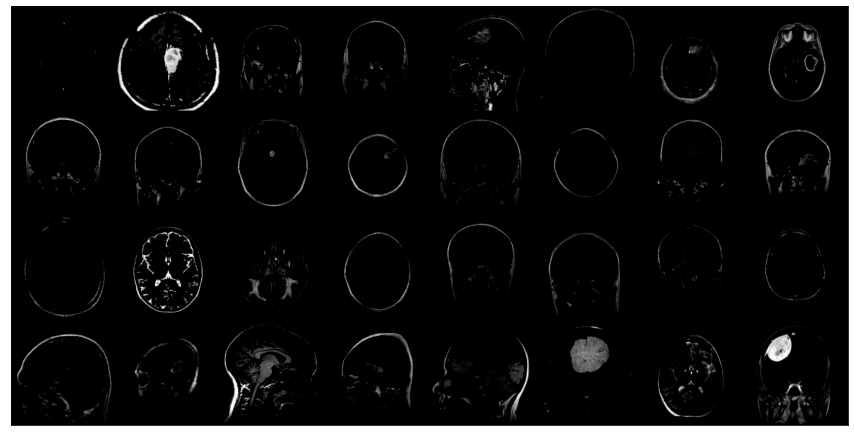

In [10]:
examples = iter(train_loader)
img,labels = examples.next()
def show_batch(dataset_loader):
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img).permute(1, 2, 0))
show_batch(train_loader)

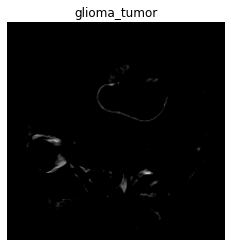

In [11]:
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{dataset_training.classes[label]}')
    plt.axis("off")
    plt.show()

show_image(*dataset_training[11])

In [12]:
y_test = np.array([y for x, y in iter(dataset_testing)])

In [13]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Pytorch and Skorch')
    y_prediction = np.argmax(y_pred, axis=1)
    report = classification_report(y_test, y_prediction, target_names=dataset_training.classes)
    print(f'{report}')
    
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {model} Pytorch and Skorch')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset_training.classes)
    disp.plot(cmap='Blues', ax=ax)

In [14]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                "id": 1,
                "variables":['train_acc', 'valid_acc'],
                "labels":['Training Accuracy', 'Validation Accuracy'],
                "legend":'lower right',
                "title":f'Accuracy Pytorch and Skorch - {model}',
                "ylabel":'Accuracy'
            },{ 
                "id": 2,
                "variables":['train_loss', 'valid_loss'],
                "labels":['Training Loss', 'Validation Loss'],
                "legend":'upper right',
                "title":f'Loss Pytorch and Skorch - {model}',
                "ylabel":'Loss'
            }]
    
    for tab in tab_plot: 
        plt.subplot(1, 2, tab['id'])
        plt.plot(history[:, tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
        plt.plot(history[:, tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
        plt.legend(loc=tab['legend'])
        plt.title(tab['title'])
        plt.xlabel('Epochs')
        plt.ylabel(tab['ylabel'])
    plt.show()

In [15]:
train_acc = EpochScoring(scoring='accuracy', on_train=True, 
                         name='train_acc', lower_is_better=False)
callbacks = [train_acc]

In [16]:
class ModelMmobilenetV2(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(1280, output_features)
        self.model = model

      def forward(self, x):
        return self.model(x)
        
net_mobilenetv2 = NeuralNetClassifier(
    ModelMmobilenetV2,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [17]:
warnings.filterwarnings('ignore')
print('Train Mobilenetv2 Pytorch and Skorch')
net_mobilenetv2.fit(dataset_training, y=None)

Train Mobilenetv2 Pytorch and Skorch


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.8003        0.5423       0.8954        0.3035  28.2984
      2       0.9145        0.2589       0.8862        0.3544  22.1487
      3       0.9341        0.2036       0.9323        0.1852  22.4540
      4       0.9460        0.1588       0.9046        0.2923  22.3626
      5       0.9517        0.1397       0.9292        0.1697  22.1061
      6       0.9747        0.0857       0.9631        0.1161  22.6639
      7       0.9766        0.0629       0.6831        2.3308  22.3521
      8       0.9594        0.1306       0.9508        0.2039  22.0998
      9       0.9774        0.0735       0.9508        0.1615  22.4939
     10       0.9793        0.0527       0.9508        0.1419  22.5677
     11       0.9877        0.0467       0.9538        0.1477  22.6976
     12       0.9766        0.0930       0.9138        0.3737  22.0753
     1

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelMmobilenetV2(
    (model): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
     

Test Mobilenetv2 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.90      0.93        94
meningioma_tumor       0.94      0.97      0.95        95
        no_tumor       0.91      0.98      0.94        50
 pituitary_tumor       0.99      0.98      0.98        91

        accuracy                           0.95       330
       macro avg       0.95      0.96      0.95       330
    weighted avg       0.96      0.95      0.95       330



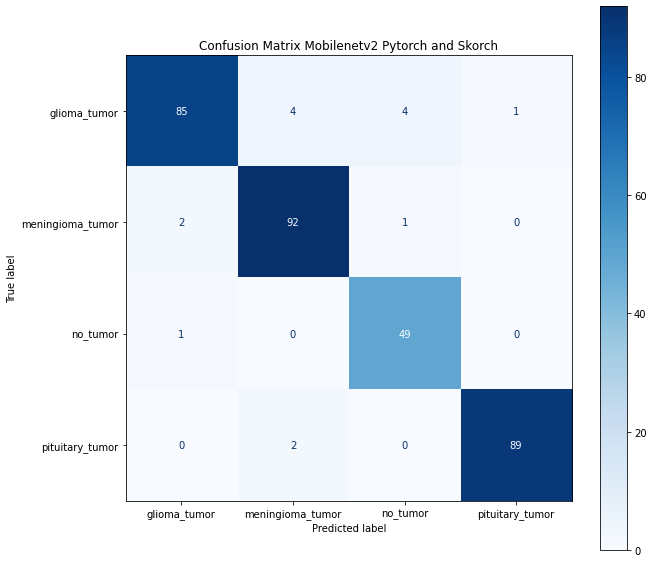

In [18]:
y_pred_mobilenetv2 = net_mobilenetv2.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_mobilenetv2,'Mobilenetv2')

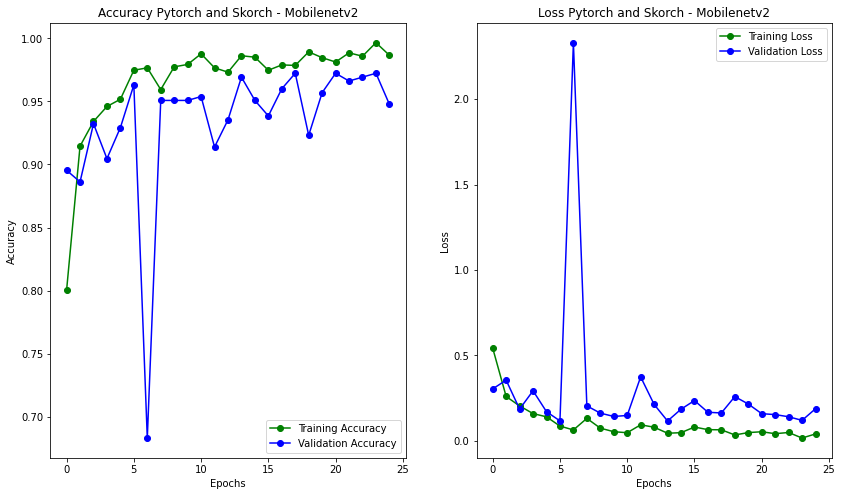

In [19]:
display_plot(net_mobilenetv2.history, 'Mobilenetv2')

In [21]:
class ModelDenseNet121(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(1024, output_features)
        self.model = model

      def forward(self, x):
        return self.model(x)
       
net_densenet121 =  NeuralNetClassifier(
    ModelDenseNet121,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [22]:
warnings.filterwarnings('ignore')
print('Train DenseNet121 Pytorch and Skorch')
net_densenet121.fit(dataset_training, y=None)

Train DenseNet121 Pytorch and Skorch


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.8340        0.4639       0.8646        0.5169  32.6352
      2       0.9019        0.2840       0.5631        2.0140  32.4190
      3       0.9237        0.2277       0.8585        0.3984  32.5610
      4       0.9318        0.1930       0.8031        0.5907  32.4252
      5       0.9483        0.1533       0.8708        0.3700  32.3891
      6       0.9590        0.1247       0.7508        0.6961  32.6597
      7       0.9621        0.1210       0.7046        0.8903  32.3988
      8       0.9506        0.1443       0.9415        0.1975  32.4628
      9       0.9839        0.0586       0.9354        0.2522  32.4187
     10       0.9843        0.0558       0.9538        0.1525  32.5482
     11       0.9713        0.0778       0.8892        0.3606  32.4554
     12       0.9782        0.0615       0.7877        0.8178  32.4188
     1

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelDenseNet121(
    (model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

Test DenseNet121 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.95      0.97        94
meningioma_tumor       0.95      0.96      0.95        95
        no_tumor       0.94      1.00      0.97        50
 pituitary_tumor       0.98      0.98      0.98        91

        accuracy                           0.97       330
       macro avg       0.96      0.97      0.97       330
    weighted avg       0.97      0.97      0.97       330



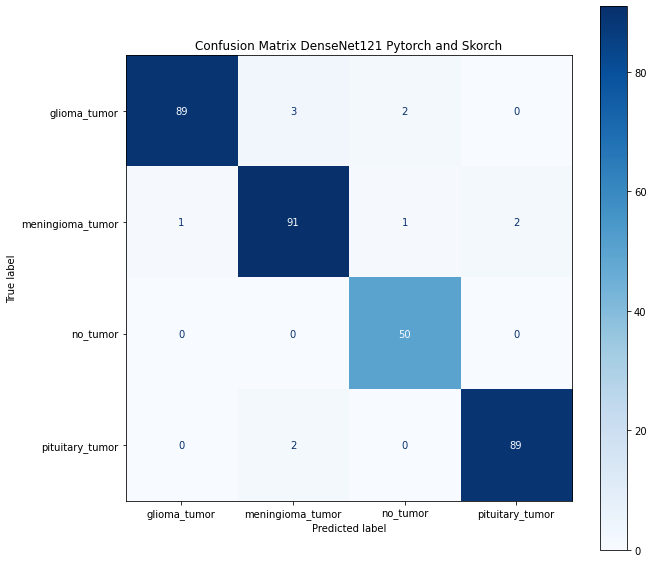

In [23]:
y_pred_densenet121 = net_densenet121.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_densenet121, 'DenseNet121')

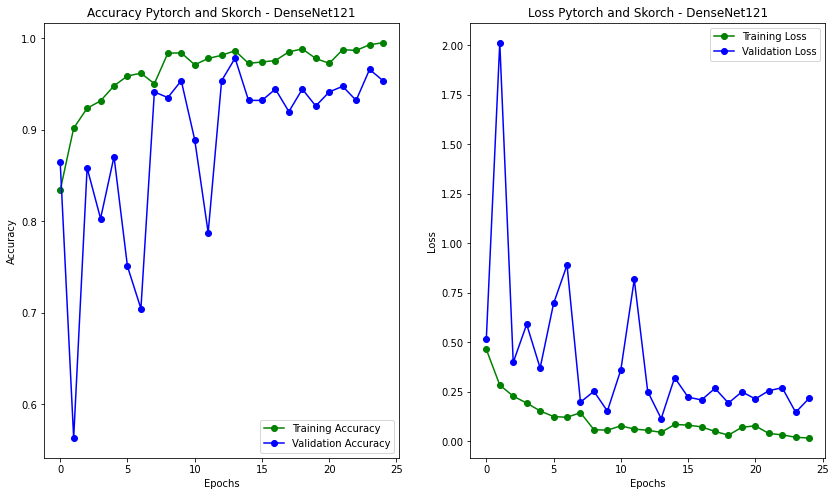

In [24]:
display_plot(net_densenet121.history, 'DenseNet121')

In [28]:
class ModelResnet50(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(2048, output_features)
        self.model = model

      def forward(self, x):
        return self.model(x)

net_resnet50 =  NeuralNetClassifier(
    ModelResnet50,
    module__output_features=4,
    max_epochs=25,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [29]:
warnings.filterwarnings('ignore')
print('Train Resnet50 Pytorch and Skorch')
net_resnet50.fit(dataset_training, y=None)

Train Resnet50 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.7501        0.6828       0.7877        0.7757  29.8754
      2       0.8363        0.4648       0.6923        0.8143  29.8565
      3       0.9000        0.2932       0.8769        0.3387  29.8448
      4       0.9291        0.2292       0.8492        0.5074  30.0187
      5       0.9302        0.1913       0.7969        0.7894  29.6738
      6       0.9256        0.2126       0.8246        0.7375  29.9103
      7       0.9525        0.1450       0.8431        0.5900  29.9140
      8       0.9525        0.1330       0.9015        0.2624  29.3058
      9       0.9682        0.1024       0.9046        0.2926  29.8203
     10       0.9766        0.0718       0.7877        0.9647  29.8909
     11       0.9379        0.1761       0.8523        0.4697  29.8413
     12       0.9720        0.0811       0.

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelResnet50(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tra

Test Resnet50 Pytorch and Skorch
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.95      0.95        94
meningioma_tumor       0.95      0.95      0.95        95
        no_tumor       0.98      0.98      0.98        50
 pituitary_tumor       0.99      0.99      0.99        91

        accuracy                           0.96       330
       macro avg       0.97      0.97      0.97       330
    weighted avg       0.96      0.96      0.96       330



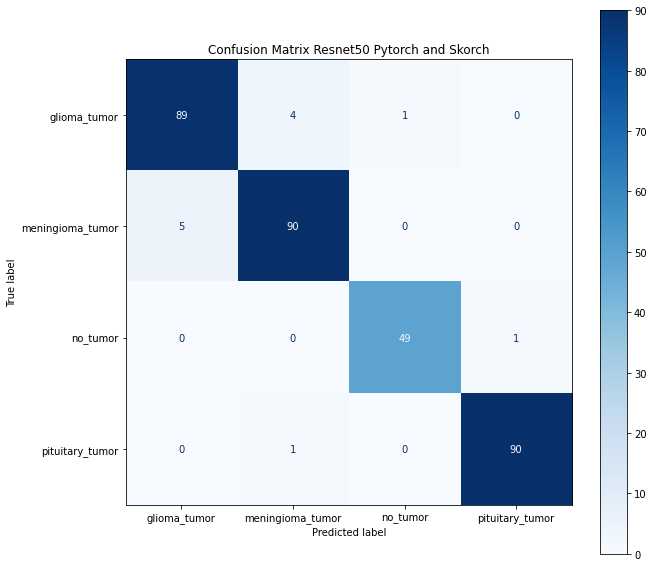

In [30]:
y_pred_resnet50 = net_resnet50.predict_proba(dataset_testing) 
display_report_and_matrix(y_pred_resnet50, 'Resnet50')

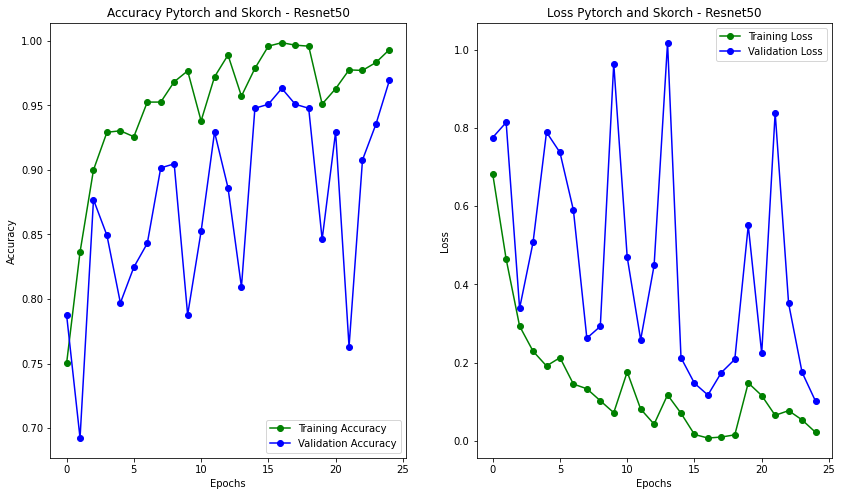

In [31]:
display_plot(net_resnet50.history, 'Resnet50')